In [41]:
import matplotlib.pyplot as plt;
import numpy as np;
import pandas as pd;
import os;

dat = pd.DataFrame(columns=["Device","Mesh","Splitting","Shading","Coloring","Resolution","Framerates"]);
print(dat);

Empty DataFrame
Columns: [Device, Mesh, Splitting, Shading, Coloring, Resolution, Framerates]
Index: []


In [ ]:
# We assume that we have a results_total directory that contains one directory per device that run the test, which in turn contains a directory for every model with each type of coloring which contains the results
# Example ./results_total/my_pc/drawing_wedge_tex.ply/uber_flat_960x540.csv
pth = "./results_total/"
devices = os.listdir("./results_total/");
for device in devices:
    for mesh_unparsed in os.listdir(pth + device):
        mesh = mesh_unparsed
        coloring = ""
        if(mesh.find("_col") != -1):
            mesh = mesh.replace("_col", "")
            coloring += "color"
        if(mesh.find("_tex") != -1):
            mesh = mesh.replace("_tex", "")
            coloring += "texture"
        if(mesh.find("_vert") != -1):
            mesh = mesh.replace("_vert", "")
            coloring = "vertex " + coloring
        if(mesh.find("_face") != -1):
            mesh = mesh.replace("_face", "")
            coloring = "face " + coloring
        if(mesh.find("_wedge") != -1):
            mesh = mesh.replace("_wedge", "")
            coloring = "wedge " + coloring
        for csv_file in os.listdir(pth + device + "/" + mesh_unparsed):
            splitting = ""
            shading = ""
            resolution = ""
            framerates = []
            for splits in ["uber", "split", "uber_static_if"]:
                if csv_file.find(splits) != -1:
                    splitting = splits
            for shad in ["flat", "smooth"]:
                if csv_file.find(shad) != -1:
                    shading = shad
            for res in ["960x540", "2560x1440"]:
                if csv_file.find(res) != -1:
                    resolution = res
            with open(pth + device + "/" + mesh_unparsed + "/" + csv_file) as f:
                file_string = f.read()
                framerates = [float(x) for x in file_string.split("\n") if x!=""]
            dat = pd.concat([dat, pd.DataFrame([[device,mesh,splitting,shading,coloring,resolution,framerates]], columns=dat.columns)], ignore_index=True)





        

In [43]:
print(dat)

             Device            Mesh       Splitting Shading       Coloring  \
0        hp_g250_80  ESTE_PRINT.ply           split    flat     face color   
1        hp_g250_80  ESTE_PRINT.ply           split    flat     face color   
2        hp_g250_80  ESTE_PRINT.ply           split  smooth     face color   
3        hp_g250_80  ESTE_PRINT.ply           split  smooth     face color   
4        hp_g250_80  ESTE_PRINT.ply            uber    flat     face color   
..              ...             ...             ...     ...            ...   
211  pc_laboratorio       myram.ply            uber  smooth  wedge texture   
212  pc_laboratorio       myram.ply  uber_static_if    flat  wedge texture   
213  pc_laboratorio       myram.ply  uber_static_if    flat  wedge texture   
214  pc_laboratorio       myram.ply  uber_static_if  smooth  wedge texture   
215  pc_laboratorio       myram.ply  uber_static_if  smooth  wedge texture   

    Resolution                                         Framerat

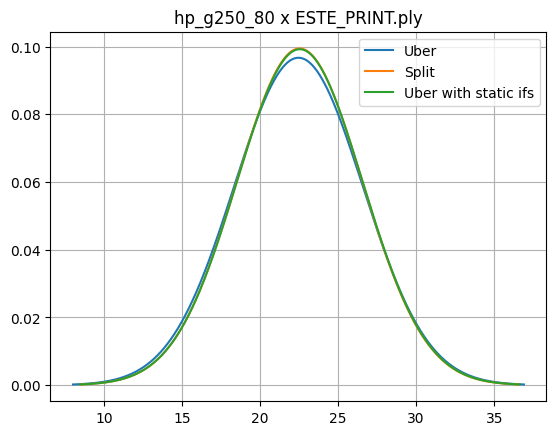

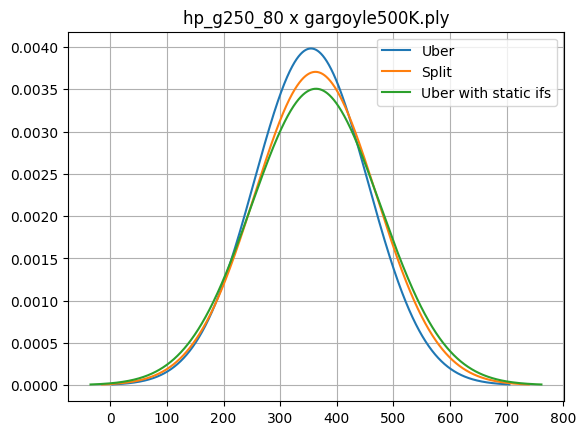

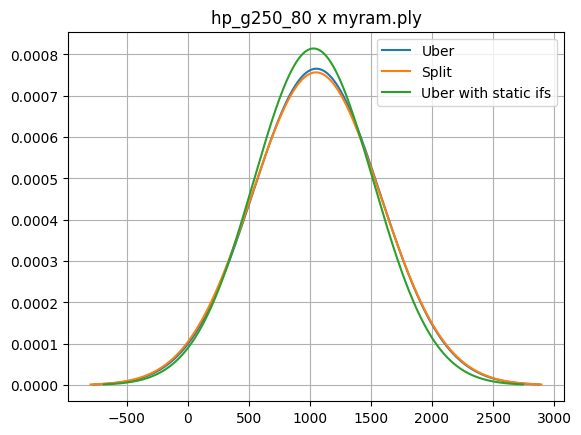

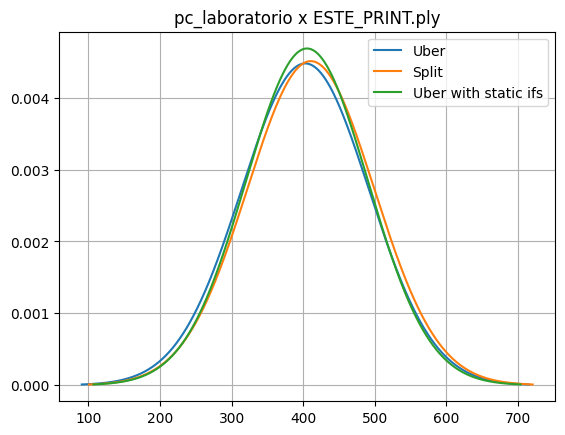

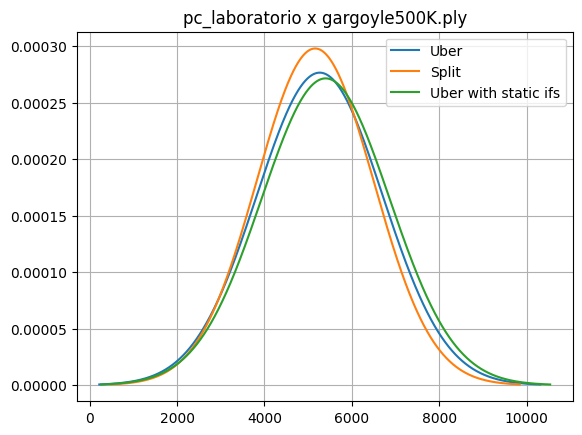

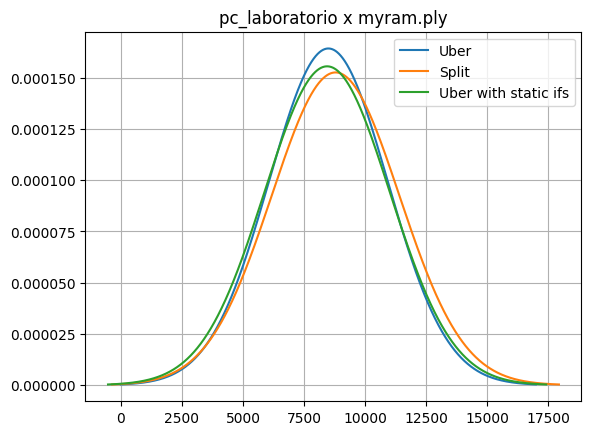

In [46]:
from scipy.stats import norm;

def per_model_plot(dataset, device, mesh):
    filtered = dataset[dataset.Device == device]
    filtered = filtered[filtered.Mesh == mesh]
    arrs = []
    for splits in ["uber", "split", "uber_static_if"]:
        arrs.append([x for y in (filtered[filtered.Splitting == splits])["Framerates"].tolist() for x in y])
    plt.grid(visible=True)
    plt.title(device + " x " + mesh)
    plot_gaussians(arrs, ["Uber", "Split", "Uber with static ifs"])

def plot_gaussians(arrs, legend):
    for arr in arrs:
        avg = np.average(arr)
        std = np.std(arr)
        x_axis = np.arange(avg-(std * 3.5), avg+(std * 3.5), 0.001)
        plt.plot(x_axis, norm.pdf(x_axis, avg, std))
    plt.legend(legend)
    plt.show()

for device in devices:
    for mesh in dat["Mesh"].unique():
        per_model_plot(dat, device, mesh)